In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import illustris_python as il
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import MDS
import networkx as nx
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
import time
import scipy.linalg

In [3]:
basePath = 'data'

In [4]:
fields = ['SubhaloFlag', 'SubhaloMass','SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloLenType', 
          'SubhaloStarMetallicity', 'SubhaloSFR', 'SubhaloGasMetallicity', 'SubhaloGasMetalFractions']
subhalos = il.groupcat.loadSubhalos(basePath,99,fields=fields)

In [5]:
subhalos.keys()

dict_keys(['count', 'SubhaloFlag', 'SubhaloMass', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloLenType', 'SubhaloStarMetallicity', 'SubhaloSFR', 'SubhaloGasMetallicity', 'SubhaloGasMetalFractions'])

In [6]:
for i in range(3):
    subhalos['SubhaloPos'][:,i] = ((subhalos['SubhaloPos'][:,i]) * u.kpc).to(u.Mpc)

In [7]:
def impose_cut(subhalos, boolean_array):
    for key in subhalos.keys():
        if key != 'count':
            subhalos[key] = subhalos[key][boolean_array]
        else:
            subhalos[key] = sum(boolean_array)
    return subhalos

In [8]:
# subhalos = impose_cut(subhalos, subhalos['SubhaloMass']*1e10 >=1e9) # subhalo mass > 1e9 Msun
subhalos = impose_cut(subhalos, subhalos['SubhaloMassType'][:,4]*1e10 >=1e9) # subhalo mass > 1e9 Msun
subhalos = impose_cut(subhalos, subhalos['SubhaloFlag'] > 0) # is actually a subhalo
subhalos = impose_cut(subhalos, subhalos['SubhaloLenType'][:,4] > 100) # more than 50 star particles

In [9]:
subhalos['SubhaloPos'].shape

(17611, 3)

In [10]:
limit = 80
for i in range(3):
    subhalos = impose_cut(subhalos, subhalos['SubhaloPos'][:,i] < limit)

In [11]:
subhalos['count']

17611

In [12]:
subhalos['SubhaloPos']

array([[ 0.8490915 , 26.326998  , 18.306934  ],
       [ 0.10647334, 24.633324  , 16.900553  ],
       [ 0.8531124 , 26.72575   , 17.510681  ],
       ...,
       [36.158207  , 74.77495   , 70.913055  ],
       [23.255453  , 67.40363   , 73.68266   ],
       [45.46694   , 36.893852  , 72.4918    ]], dtype=float32)

In [13]:
t = time.time()
original_distance_matrix = euclidean_distances(subhalos['SubhaloPos'],subhalos['SubhaloPos']) # supposedly takes ~20 sec
print(time.time() - t)

1.2905521392822266


(array([6.7987590e+06, 2.5993442e+07, 4.8950832e+07, 6.5961454e+07,
        7.0511338e+07, 5.6999218e+07, 2.7294628e+07, 6.9643800e+06,
        6.6697000e+05, 6.3000000e+03]),
 array([  0.        ,  12.06612587,  24.13225174,  36.19837952,
         48.26450348,  60.33063126,  72.39675903,  84.462883  ,
         96.52900696, 108.59513855, 120.66126251]),
 <BarContainer object of 10 artists>)

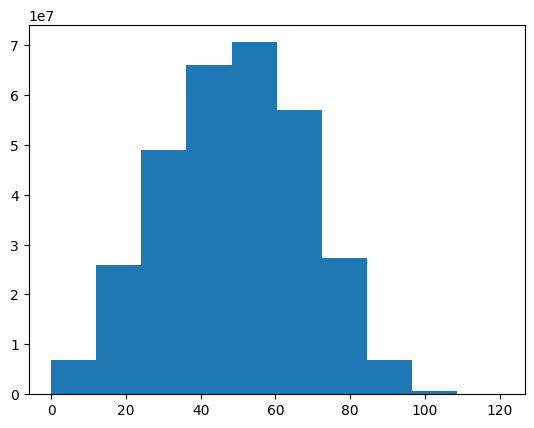

In [13]:
plt.hist(original_distance_matrix.flatten())

for every galaxy, calculate the distance to every other galaxy for every possible transformation, then pick the minimum.

In [14]:
h = limit / 2
possible_transforms = np.array([[0, 0, h], [0, h, 0], [h, 0, 0], [h, h, 0], [h, -h, 0], [0, h,h], [0, -h,h], [h, 0,h], [h, 0,-h], [h,h,h], [-h,h,h], [h,-h,h],[h,h,-h]])
possible_transforms = np.vstack(([0,0,0], possible_transforms, -possible_transforms))

In [15]:
possible_transforms.shape

(27, 3)

In [16]:
num_transforms = possible_transforms.shape[0]
possible_distances = np.zeros((num_transforms, subhalos['count'], subhalos['count']))

original_positions = subhalos['SubhaloPos']
for i in range(num_transforms):
    # print(i)
    possible_distances[i] = euclidean_distances(original_positions, original_positions + possible_transforms[i])

In [17]:
distance_matrix = np.min(possible_distances, axis=0)

In [18]:
possible_distances[:,2,3]

array([ 1.7445138 , 38.3834449 , 39.82930145, 39.42626967, 56.01571802,
       56.31252804, 55.28669612, 55.5873989 , 54.99705677, 57.30781121,
       67.88229651, 68.59468898, 68.12742714, 69.76757952, 41.62688812,
       40.24566316, 40.64056984, 57.16927489, 56.87693595, 57.87458759,
       57.58582933, 58.14989599, 55.87397812, 70.69710374, 70.00610902,
       70.46091348, 68.83728282])

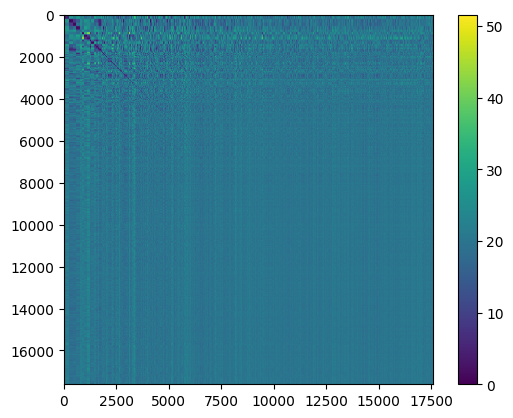

In [19]:
plt.imshow(distance_matrix)
plt.colorbar()

(array([3.7198550e+06, 1.9512512e+07, 4.9046414e+07, 9.0665178e+07,
        8.8907804e+07, 4.2036018e+07, 1.3038996e+07, 2.9192620e+06,
        2.9413600e+05, 7.1460000e+03]),
 array([ 0.        ,  5.15721153, 10.31442305, 15.47163458, 20.62884611,
        25.78605764, 30.94326916, 36.10048069, 41.25769222, 46.41490375,
        51.57211527]),
 <BarContainer object of 10 artists>)

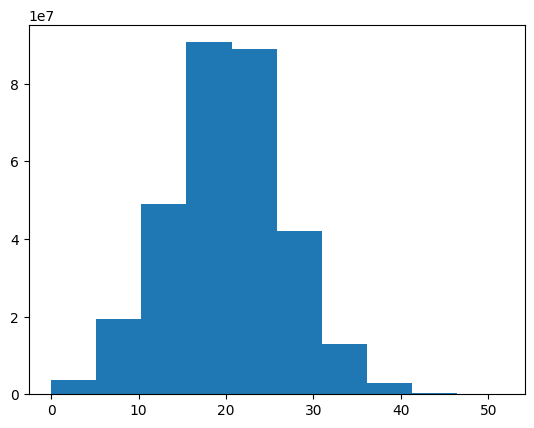

In [20]:
plt.hist(distance_matrix.flatten())

In [21]:
np.max(distance_matrix)

51.57211527479966

In [23]:
def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [24]:
masked_distance_matrix = distance_matrix * 1.*(distance_matrix <= 10)

In [ ]:
plt.imshow(masked_distance_matrix)
plt.colorbar()

Here, I want the edge weights to mean similarity, where 1 is most similar and 0 is not similar... So, I will use inverse squared weighting.

In [ ]:
num_galaxies = subhalos['count']
edge_list = []
for i in range(num_galaxies):
    for j in range(i):
        if masked_distance_matrix[i][j] > 0:
            edge_list.append((i, j, 1 / (distance_matrix[i][j]**2)))
        # edge_list.append((j, i, distance_matrix[i][j])) # for directed graph hack

In [ ]:
len(edge_list)

limit connections to be within 150 MPc (this is where distance metrics don't matter)

In [33]:
np.savetxt('tng50_inverse_edgelist_all.txt', edge_list, fmt='%d')

In [14]:
nodes, *emb = np.loadtxt("struc2vec/emb/tng_inverse_all_8.emb", skiprows=1).T

emb = np.array(emb)
nodes = np.array(nodes, dtype=np.int32)
emb = emb[:,np.argsort(nodes)] # put these in the same order as the original nodes

In [15]:
emb.shape

(8, 17611)

In [16]:
pca = PCA(n_components=8)
pca.fit(emb)
print(pca.explained_variance_ratio_)

[3.80068156e-01 1.15508533e-01 1.05454559e-01 1.03939598e-01
 1.00377185e-01 9.92875887e-02 9.53643793e-02 2.29126194e-31]


In [17]:
components = MinMaxScaler().fit_transform(pca.components_.T).T

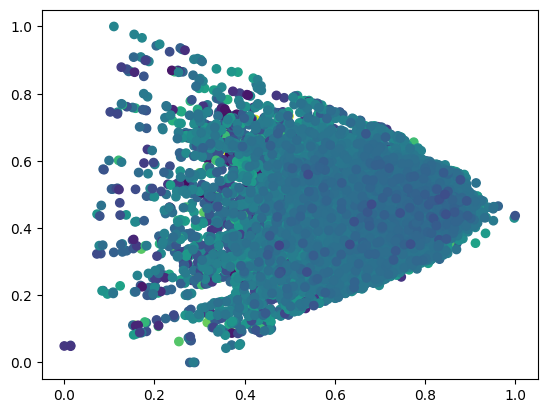

In [19]:
plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloMass']))

In [20]:
subhalos['SubhaloLenType'][:,1]

array([46136876,  6297959,  1420531, ...,     3416,     3387,     2422],
      dtype=int32)

/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_4606/436295171.py:1: RuntimeWarning:

divide by zero encountered in log10



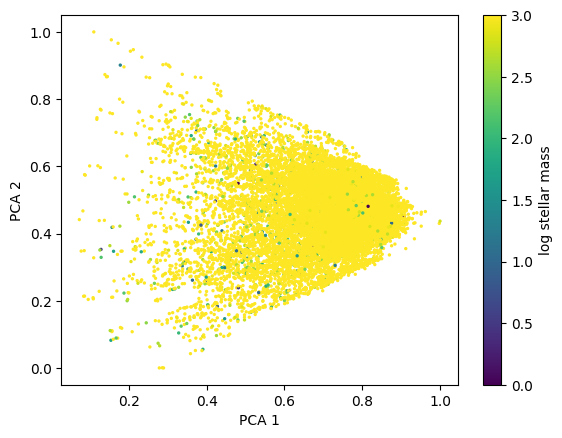

In [21]:
plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloLenType'][:,0]), s=2, vmax=3)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log stellar mass")

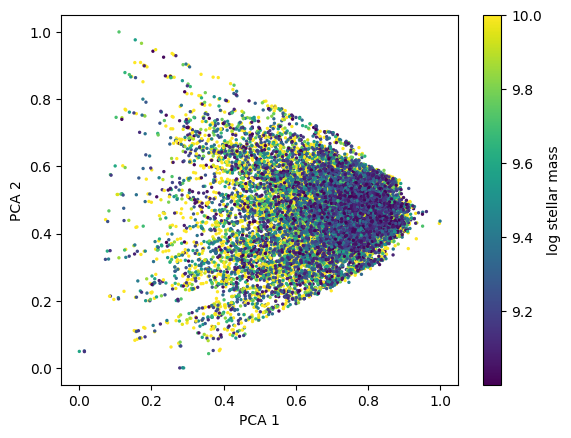

In [22]:
plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloMassType'][:,4] * 1e10), s=2, vmax=10)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log stellar mass")

In [23]:
subhalos.keys()

dict_keys(['count', 'SubhaloFlag', 'SubhaloMass', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloLenType', 'SubhaloStarMetallicity', 'SubhaloSFR', 'SubhaloGasMetallicity', 'SubhaloGasMetalFractions'])

In [24]:
subhalos['SubhaloStarMetallicity']

array([0.02862233, 0.02126505, 0.02540692, ..., 0.01384929, 0.00971744,
       0.01179481], dtype=float32)

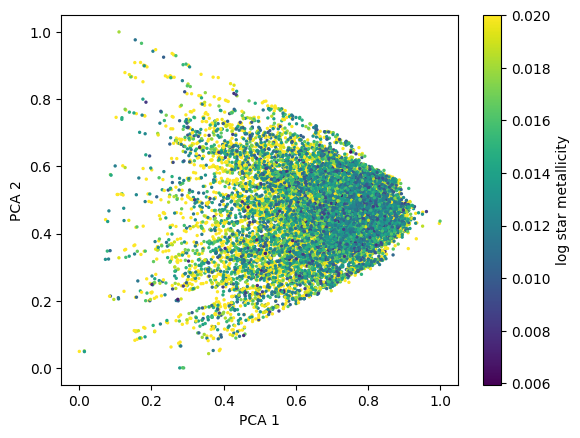

In [25]:
plt.scatter(*components[[0,1]], c = subhalos['SubhaloStarMetallicity'], s=2, vmax=0.02)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log star metallicity")

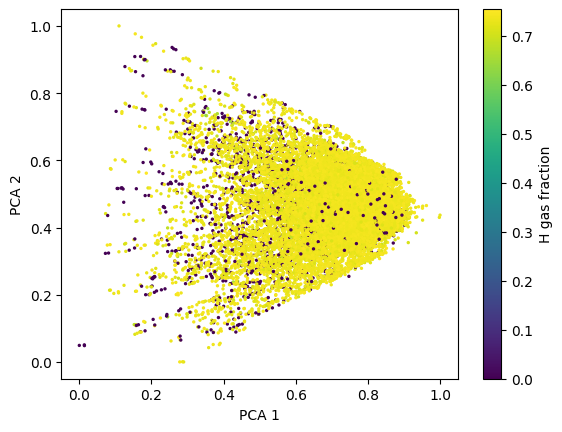

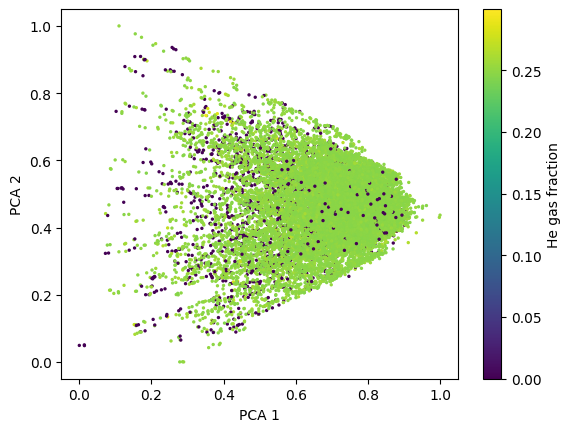

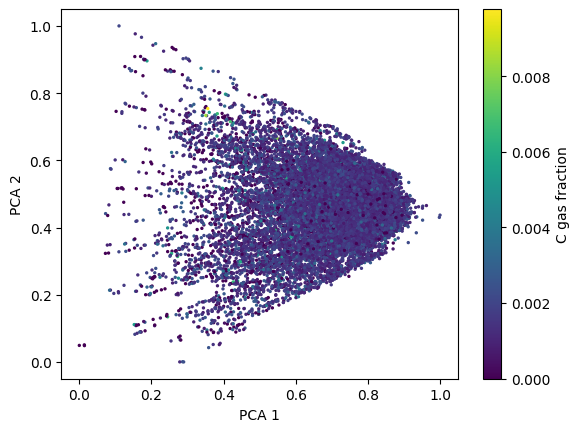

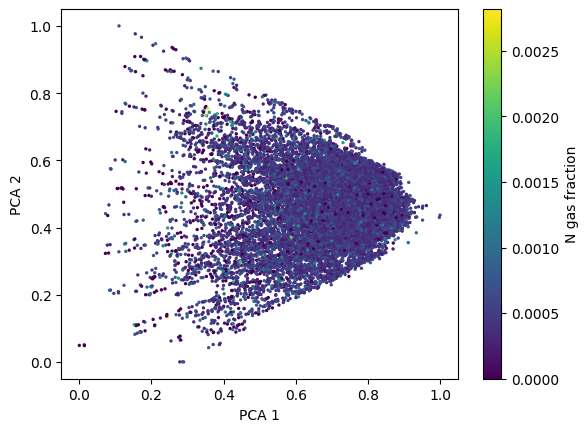

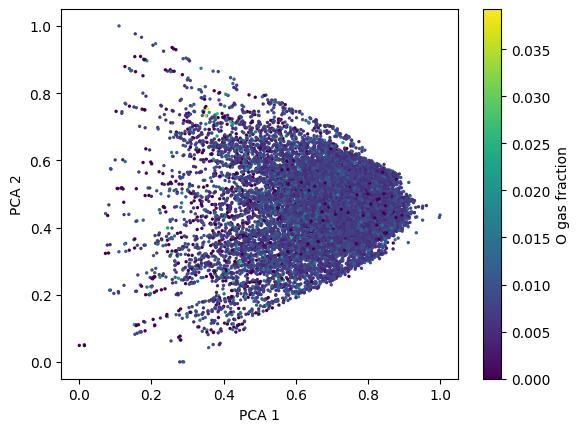

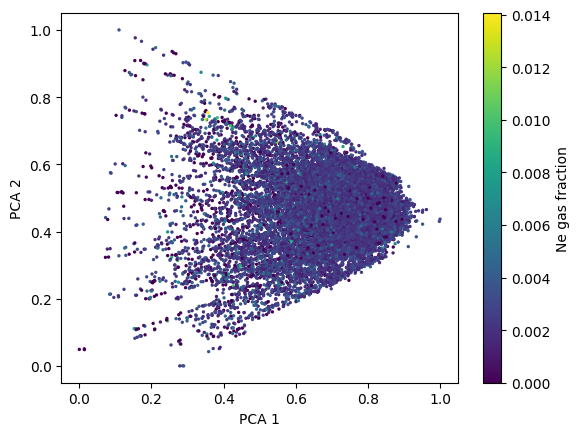

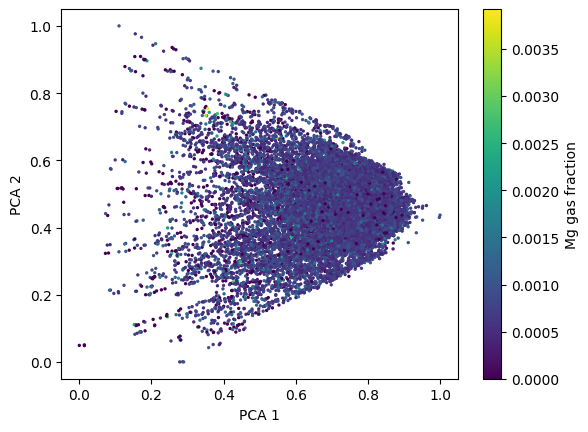

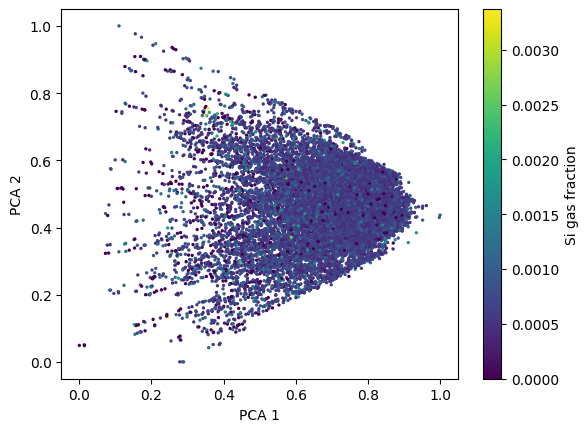

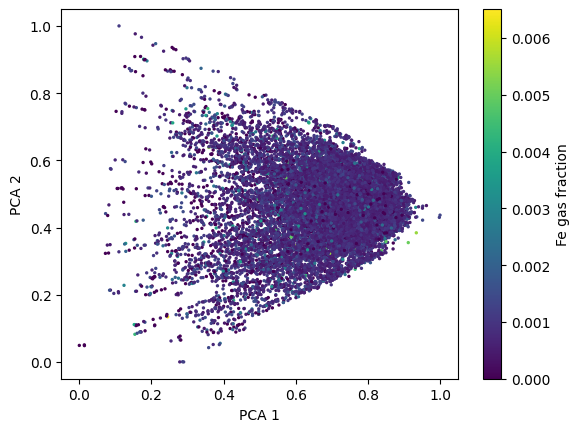

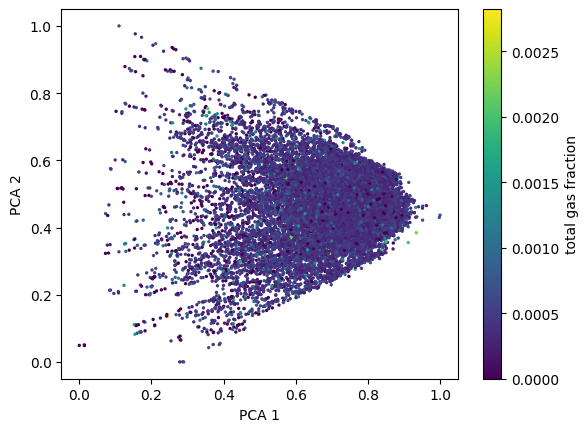

In [26]:
gases = ['H', 'He', 'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'Fe', 'total']
for i in range(10):
    fig, ax = plt.subplots()
    s = ax.scatter(*components[[0,1]], c = subhalos['SubhaloGasMetalFractions'][:,i], s=2)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    cbar = fig.colorbar(s, label=gases[i]+" gas fraction")
    plt.show()

/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_4606/3115200171.py:1: RuntimeWarning:

divide by zero encountered in log10



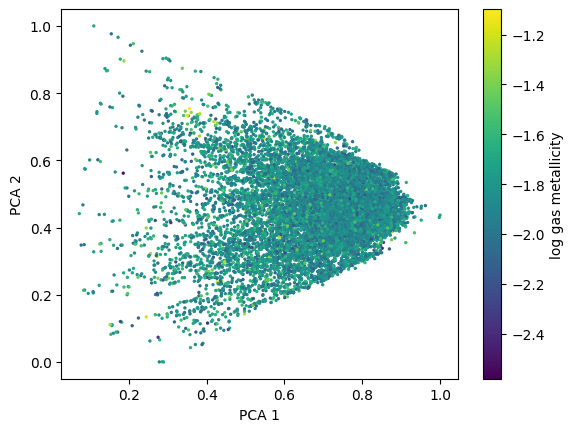

In [27]:
plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloGasMetallicity']),s=2)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log gas metallicity")

/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_4606/3025745483.py:1: RuntimeWarning:

divide by zero encountered in log10



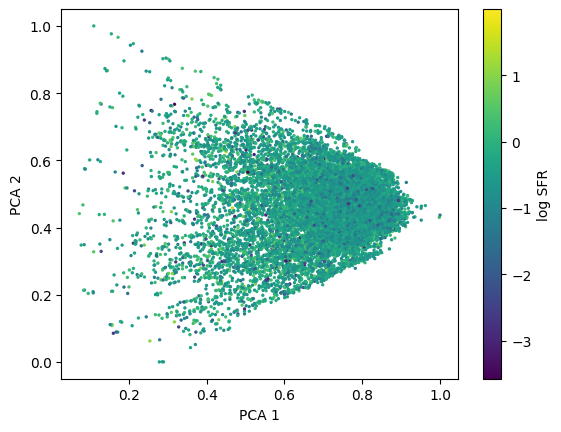

In [28]:
plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloSFR']),s=2)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log SFR")

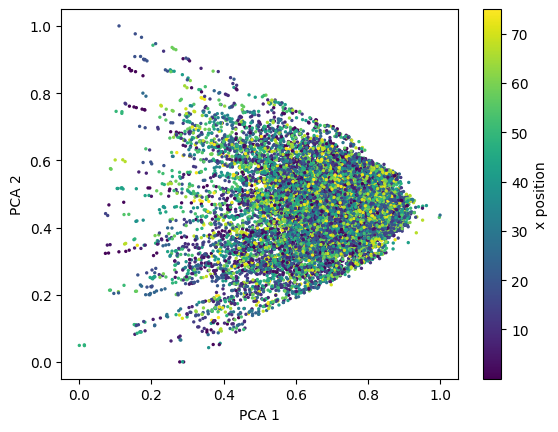

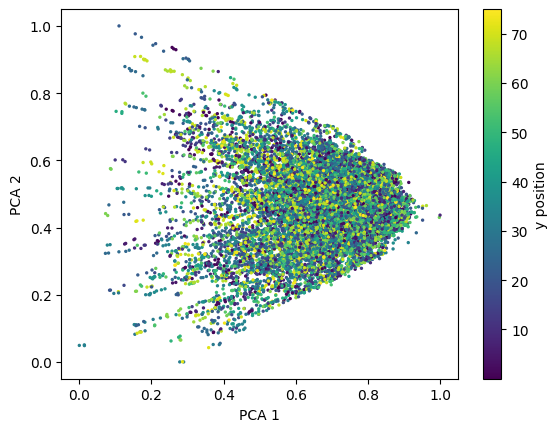

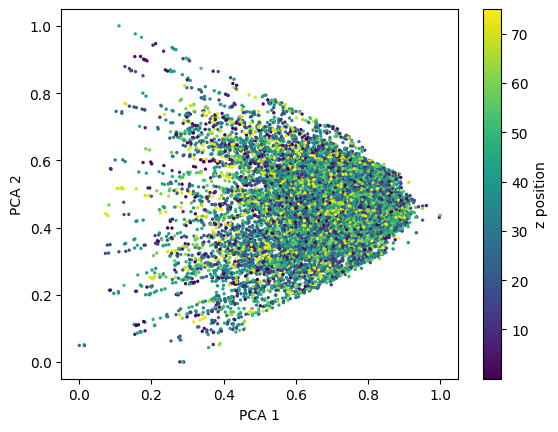

In [29]:
l = ["x", "y", "z"]
for i in range(3):
    plt.scatter(*components[[0,1]], c = subhalos['SubhaloPos'][:,i],s=2)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.colorbar(label=l[i]+" position")
    plt.show()

In [35]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot
# df = px.data.iris()
fig = px.scatter_3d(x=subhalos['SubhaloPos'][:,0], y=subhalos['SubhaloPos'][:,1], z=subhalos['SubhaloPos'][:,2],
                    color=components[0])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
plot(fig, filename='struc2vecembedding.html', auto_open=True)


'struc2vecembedding.html'

In [36]:
fig = px.scatter_3d(x=components[0], y=components[1], z=components[2],
                    color=np.clip(subhalos['SubhaloStarMetallicity'], 0, 0.02))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
plot(fig, filename='galaxies.html', auto_open=True)


'galaxies.html'

distance to the boundary

plot positions and color by altent representation

weights by inverse square of distance

In [32]:
G = nx.Graph()
G.add_nodes_from(np.arange(subhalos['count']))

In [33]:
# ebunch = [(i[0], i[1], {'weight':i[2]}) for i in edge_list[::2]]
ebunch = [(i[0], i[1], i[2]) for i in edge_list]
G.add_weighted_edges_from(ebunch)

NameError: name 'edge_list' is not defined

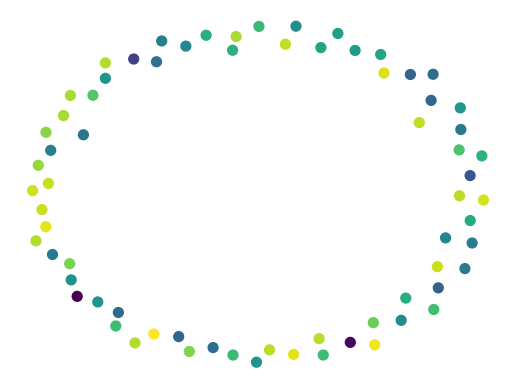

In [34]:
fig, ax = plt.subplots()
num_nodes = 70
subgraph = G.subgraph(np.arange(num_nodes))
nx.draw(subgraph, node_size=50, ax = ax, width = list(nx.get_edge_attributes(subgraph, "weight").values()), node_color = components[0][:num_nodes])

In [57]:
cmap = mpl.colormaps['Spectral']

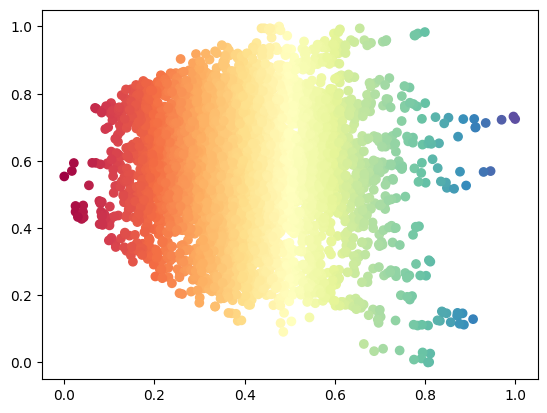

In [58]:
f = plt.scatter(components[0], components[1], c =components[0], cmap=cmap)

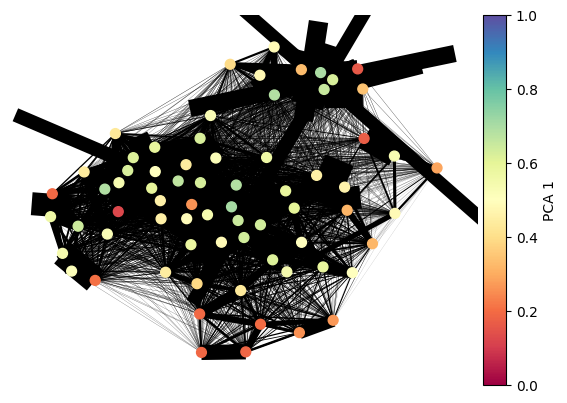

In [59]:
fig,ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
nx.draw(subgraph, pos = nx.spring_layout(subgraph), node_size=50, ax = ax, width = list(nx.get_edge_attributes(subgraph, "weight").values()), node_color = cmap(components[0][:num_nodes]))
cbar = plt.colorbar(f, cax=cax)
cbar.set_label("PCA 1")
plt.show()

In [352]:
# filename = "snap_099.0.hdf5"
# with h5py.File(filename, "r") as f:
#     # Print all root level object names (aka keys) 
#     # these can be group or dataset names 
#     print("Keys: %s" % f.keys())
#     # get first object name/key; may or may NOT be a group
#     a_group_key = list(f.keys())[0]
#     for key in f.keys():
#         print(key)
#         print(list(f[key]))
    
#     print(type(f[a_group_key])) 
